In [ ]:
import hdf5storage
import rat.helpers as helpers
import rat.get_data as get_data
import numpy as np
from bat.helpers_bat import *


%load_ext autoreload
%autoreload 2


## Loading in the bat data (LFP and positional data)
We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a different file, but luckily the accessors for this were provided by the Yartsev lab (thanks Kevin Qi!).

In [ ]:
# Loading bat LFP data
lfp_mat = hdf5storage.loadmat('./bat/data/ephys/32622_231007_lfp.mat')

# Check the structure of lfp_mat
print("Structure of lfp_mat:", type(lfp_mat['lfp']), lfp_mat['lfp'].shape)


In [ ]:
data_path = './bat/data' # Replace this
bat_id = '32622'
date =  '231007'

In [ ]:
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

In [ ]:
pos = session.cortex_data.bat_pos
pos.shape # (num_timepoints, XYZ)

Since the position data has a lot of NaNs throughout it, we can interpolate across these spans of NaN values to create a cleaner dataset. More on how this affects the data in ```example.ipynb```.

In [ ]:
cleaned_pos = np.copy(pos)
# still position on walls are nans (dont interpolate large gaps of nans)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])
cleaned_pos.shape

## Time synchronization
Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [ ]:
timestamps = lfp_mat['global_sample_timestamps_usec'] #global timestamps in microseconds

np.diff(timestamps.flatten()) #we will see a 400 microsecond difference between each timestamp,
#which means that the sampling rate is 2500 Hz

In [ ]:
timestamps.shape

Above, we filtered out the negative timestamps from the position recording relative to the global timestamp start. We simply had to filter out the corresponding samples in position to synchronize. Now we're ready to make timebins from the LFP timestamp data and bin the positional data accordingly.

In [ ]:
from scipy.signal import decimate

lfp_timestamps_decimated_bins = decimate(timestamps.flatten(), 100) #decimate from 2500 Hz to 25 Hz (100x decimation)
lfp_timestamps_decimated_bins.shape
lfp_timestamps_decimated_bins[0:10]


Now that we downsampled the LFP timestamps, we will lop off negative timestamps to ensure that we have proper "edges" between bins (more on this later).

In [ ]:
lfp_indices = lfp_timestamps_decimated_bins > 0
lfp_timestamps_decimated_bins = lfp_timestamps_decimated_bins[lfp_indices] # lop off negative timestamps
lfp_timestamps_decimated_bins = np.insert(lfp_timestamps_decimated_bins, 0, 0) # insert 0 at the beginning

lfp_timestamps_decimated_bins.shape
lfp_timestamps_decimated_bins[0:10]

We now have our decimated LFP timebins. Inside of ```lfp_timestamps_decimated_bins```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average out points between edges of the LFP timebins to get synchronized data streams.

In [ ]:
pos_timestamps = session.cortex_data.cortex_global_sample_timestamps_sec * 1e6 #converting to microseconds (usec)
valid_indices = pos_timestamps > 0 #we can use this to get rid of negative timestamps on anything position related

pos_timestamps = pos_timestamps[valid_indices] # lop off negative timestamps 
np.diff(pos_timestamps) #we will see an average of a 8333 microsecond difference between each timestamp, meaning that the sampling rate is around 120 Hz


In [ ]:
cleaned_pos = cleaned_pos[valid_indices] # lop off the corresponding positions
cleaned_pos.shape

In [ ]:
# Bin positional data using the provided label_timebins function
binned_pos_x = label_timebins(lfp_timestamps_decimated_bins, cleaned_pos[:, 0], pos_timestamps, is_discrete=False)
binned_pos_y = label_timebins(lfp_timestamps_decimated_bins, cleaned_pos[:, 1], pos_timestamps, is_discrete=False)
binned_pos_z = label_timebins(lfp_timestamps_decimated_bins, cleaned_pos[:, 2], pos_timestamps, is_discrete=False)

In [ ]:
binned_pos = np.zeros((3,len(binned_pos_x)))
# Assign binned positions to binned_pos array
binned_pos[0, :] = binned_pos_x
binned_pos[1, :] = binned_pos_y
binned_pos[2, :] = binned_pos_z

# Replace the first element with 0 and trim last element
binned_pos[:, 0] = 0
binned_pos = binned_pos[:, :-1]
lfp_timestamps_decimated_bins = lfp_timestamps_decimated_bins[:len(binned_pos[0])]

# Verify the results
print("Binned position shape:", binned_pos.shape)
print("LFP timestamps shape:", lfp_timestamps_decimated_bins.shape)
print("First few elements of binned_pos:\n", binned_pos[:, :5])
print("First few LFP timestamps:", lfp_timestamps_decimated_bins[:5])

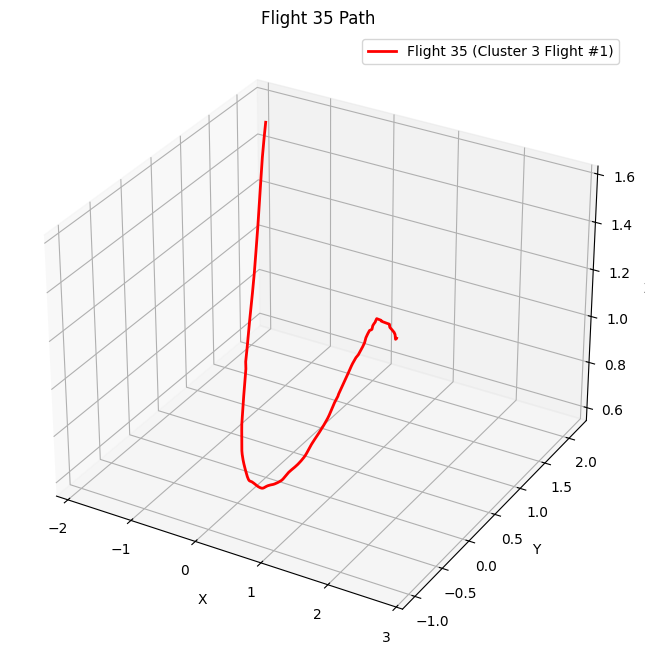

In [37]:
from bat.helpers_bat import get_cluster_labels, get_flight_boolean_array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.colors as mcolors

clutser_2_labels = get_cluster_labels(session, 2)

# Get boolean array for the 35th flight overall (which might be in cluster 3)
flight_35_bool, flight_35_cluster = get_flight_boolean_array(session, 35)

# Create a new figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the boolean array for indexing or plotting
ax.plot(pos[flight_35_bool, 0], pos[flight_35_bool, 1], pos[flight_35_bool, 2],
        color='red', linewidth=2, label=f'Flight 35 (Cluster 3 Flight #1)')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Flight 35 Path')

# Add legend
ax.legend()

# Show the plot
plt.show()

We are creating labels (timebin_labels) to associate which timebins are related to which flight so we can access them accordingly.

In [38]:
labels = flight_35_bool[valid_indices] # we can also do this by cluster with labels = cluster_2_labels[valid_indices]
labels.shape

(824435,)

In [39]:
timebin_labels = label_timebins(lfp_timestamps_decimated_bins, labels, pos_timestamps, is_discrete=True)

In [40]:
print(len(binned_pos[0]), len(binned_pos[1]), len(timebin_labels))

170689 170689 170688


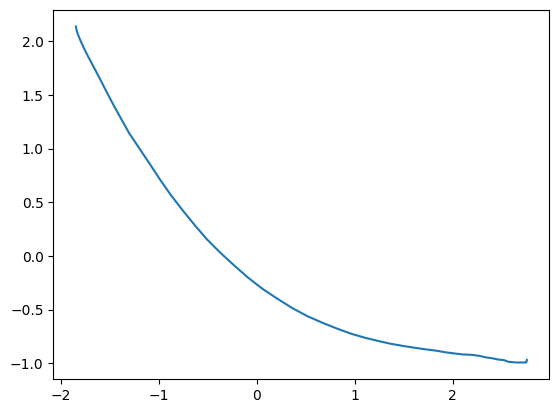

In [41]:
plt.plot(binned_pos[0][:len(timebin_labels)][timebin_labels >0], 
         binned_pos[1][:len(timebin_labels)][timebin_labels >0])

Using timebin_labels, we can filter out the binned position data for each flight. This will allow us to organize flight data later.

### Organizing behavioral data
To better organize the binned flight data, we need to construct a flightID array which will contain all the binned positions for each flight, accounting for which feeder (or the perch) was visited for each data point entered in that flight.

## LFP extraction and downsampling

In [ ]:
# Extract subarrays and check their structure
lfp_data_1 = lfp_mat['lfp'][0, 0]
lfp_data_2 = lfp_mat['lfp'][0, 1]

print(f"Type of lfp_data_1: {type(lfp_data_1)}, Shape of lfp_data_1: {lfp_data_1.shape}")
print(f"Type of lfp_data_2: {type(lfp_data_2)}, Shape of lfp_data_2: {lfp_data_2.shape}")

n_channels = lfp_data_1.shape[0] #same # of channels for lfp_data_1 and lfp_data_2 (change if not the case)


In [ ]:

# bat LFP data sampled at 2500 Hz
lfp_bat_1 = get_data.get_LFP_from_mat(lfp_data_1,n_channels,2500)
lfp_bat_2 = get_data.get_LFP_from_mat(lfp_data_2,n_channels,2500)

lfp_bat_combined = np.concatenate((lfp_bat_1, lfp_bat_2), axis=1)


In [ ]:
print("lfp_bat_1 shape:", lfp_bat_1.shape) # (n_samples, n_channels)
print("lfp_bat_2 shape:", lfp_bat_2.shape) # (n_samples, n_channels)
print("lfp_bat_combined shape:", lfp_bat_combined.shape) # (n_samples, 2*n_channels)

Once LFP is loaded in, we can downsample to 25hz and apply a Hilbert transform. We can then filter out the negative timestamps and apply that to the lfp.

In [ ]:
LFPs = helpers.filter_data(lfp_bat_combined, 0.1, fs=25, use_hilbert=True)
LFPs.shape

In [ ]:
LFPs = LFPs[lfp_indices]
LFPs.shape

# Applying TIMBRE


In [ ]:
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE
from bat.helpers_bat import *

fig, axs = plt.subplots(4, 4, figsize=(20, 5))

n_folds = 5
which_fold = 0
num_samples_at_end = 5  # Number of samples at the end of each flight to use for classification

test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold, num_samples_at_end)

wLFPs, _, _ = helpers.whiten(bin_LFP, train_inds)

# Verify the shapes of the indices arrays
#print(f"Test indices shape: {test_inds.shape}")
#print(f"Train indices shape: {train_inds.shape}")

# Assuming `wLFPs` and `flightID` are used in TIMBRE
#print(f"wLFPs shape: {wLFPs.shape}")
#print(f"flightID shape: {flightID.shape}")


#n_bins = 20
#pos_binned = helpers.group_by_pos(data['lapID'][:, 4], n_bins, train_inds)  # Convert position along the track into discrete bins.
#arm_and_pos_binned = data['lapID'][:, 1] * n_bins + pos_binned  # Represent arm x position as integer between 0-19 (arm 1), 20-39 (arm 2), 40-59 (arm 3)
# Additional debug statements to verify input to TIMBRE
print(f"X (wLFPs) shape: {wLFPs.shape}")
print(f"Y (flightID[:, 1]) shape: {flightID[:, 1].shape}")
print(f"inds_train shape: {train_inds.shape}")
print(f"inds_test shape: {test_inds.shape}")
print(f"X[inds_train, :] shape: {wLFPs[train_inds, :].shape}")
print(f"Y[inds_train] shape: {flightID[train_inds, 1].shape}")
print(f"X[inds_test, :] shape: {wLFPs[test_inds, :].shape}")
print(f"Y[inds_test] shape: {flightID[test_inds, 1].shape}")


titles = ['Projection (real part)', 'Amplitude', 'Softmax 1', 'Softmax 2 (Output)'];
for i in range(axs.shape[0]):
    print(f"Training network {i + 1} of {axs.shape[0]} (hidden layer size {3 * 2 ** i})")  # try 4 different hidden layer sizes
    m, _, _ = TIMBRE(wLFPs, flightID[:, 1], test_inds, train_inds, hidden_nodes=3, learn_rate=0.001, is_categorical=True, verbosity=1)
    for j in range(axs.shape[1]):  # Loop through each layer
        p = helpers.layer_output(wLFPs[test_inds], m, j)  # Calculate layer's response to input, using only test data
        if j == 0:
            p = p[:, :p.shape[1] // 2]  # just get real component for complex-valued output
            axs[i, 0].set_ylabel(str(3 * 2 ** i) + ' features');
        if i == 0:
            axs[0, j].set_title((titles[j]));
        #axs[i, j].plot(helpers.accumarray(arm_and_pos_binned[test_inds], p));  # plot mean response of layer to test data as a function of position
        axs[i, j].autoscale(enable=True, axis='both', tight=True);
        if i < axs.shape[0] - 1:
            axs[i, j].set_xticks([]);
        else:
            axs[i, j].set_xlabel('Position');
